In [161]:
import numpy as np
import tensorly as tl
from tensorly.cp_tensor import cp_to_tensor
import matplotlib.pyplot as plt
import random
random.seed(42)

In [162]:
alpha = 000.1  # Influence parameter
lambda_ = 1000  # Drift parameter
sigma = 1000  # Diffusion parameter
T = 1.0  # Total time
dt = 0.001  # Time step
n_iterations = int(T / dt)

n_particles = 100 # initial random tensors
I, J, K = 10, 12, 14
rank = 5  # Rank of the decomposition

# Create a random tensor
tensor = tl.tensor(np.random.random((I, J, K)))

In [163]:
# Step 2: Initialize particles 1000 random A, 1000 random B, 1000 random C

particles = []
for _ in range(n_particles):
    A = np.random.randn(I, rank) # 1000 30x5 matrices
    B = np.random.randn(J, rank) # 1000 40x5 matrices
    C = np.random.randn(K, rank) # 1000 50x5 matrices
    particles.append({'A': A, 'B': B, 'C': C})

In [164]:
# particles[i], where i = [A_i, B_i, C_i] and A_i.shape = 10x5, B_i.shape = 12x5, C_i.shape = 14x5
# a{r}_{i} = particles[i-1]['A'][:,r-1]
# where r = rank from 1 to 5, i = particles from 1 to n_particles

"""
# example indexing:
a1_1 = particles[0]['A'][:,0]
b1_1 = particles[0]['B'][:,0]
c1_1 = particles[0]['C'][:,0]

a2_1 = particles[0]['A'][:,1]
b2_1 = particles[0]['B'][:,1]
c2_1 = particles[0]['C'][:,1]

a3_1 = particles[0]['A'][:,2]
b3_1 = particles[0]['B'][:,2]
c3_1 = particles[0]['C'][:,2]

a4_1 = particles[0]['A'][:,3]
b4_1 = particles[0]['B'][:,3]
c4_1 = particles[0]['C'][:,3]

a5_1 = particles[0]['A'][:,4]
b5_1 = particles[0]['B'][:,4]
c5_1 = particles[0]['C'][:,4]

# ----------------------------

a1_2 = particles[1]['A'][:,0]
b1_2 = particles[1]['B'][:,0]

# and so on"""

"\n# example indexing:\na1_1 = particles[0]['A'][:,0]\nb1_1 = particles[0]['B'][:,0]\nc1_1 = particles[0]['C'][:,0]\n\na2_1 = particles[0]['A'][:,1]\nb2_1 = particles[0]['B'][:,1]\nc2_1 = particles[0]['C'][:,1]\n\na3_1 = particles[0]['A'][:,2]\nb3_1 = particles[0]['B'][:,2]\nc3_1 = particles[0]['C'][:,2]\n\na4_1 = particles[0]['A'][:,3]\nb4_1 = particles[0]['B'][:,3]\nc4_1 = particles[0]['C'][:,3]\n\na5_1 = particles[0]['A'][:,4]\nb5_1 = particles[0]['B'][:,4]\nc5_1 = particles[0]['C'][:,4]\n\n# ----------------------------\n\na1_2 = particles[1]['A'][:,0]\nb1_2 = particles[1]['B'][:,0]\n\n# and so on"

In [165]:
particles[0]

{'A': array([[-1.37791695,  2.44201133,  0.71791917, -0.08277498, -1.75562994],
        [ 0.32403605, -0.47284699, -0.42913849, -0.21316203,  0.16075571],
        [-0.21388985, -0.70077715, -1.98047522,  1.25553328, -0.14049207],
        [-0.24775952,  1.08447578, -0.61591381, -0.4059529 , -1.7135886 ],
        [ 0.71631244,  2.61211884,  0.7980016 , -0.19609548,  0.04634661],
        [ 1.02553772, -0.93621246,  0.58036719, -0.80675462, -0.11736414],
        [-0.03698762,  0.46576544,  0.51755154,  1.66535864, -0.29645475],
        [ 0.60833395, -0.70629229,  0.38833841,  0.46719523, -0.00413638],
        [ 1.46117457,  1.12807393, -0.26009016,  0.97347141,  0.56646171],
        [-0.08715157, -0.15638528,  0.50431726,  1.4983415 ,  0.75352078]]),
 'B': array([[-1.55788944,  0.33628183,  0.02800856, -1.02795219, -0.20315273],
        [-0.35182916, -0.7142289 , -0.03309312, -1.60742573,  1.29052492],
        [-0.64565244,  0.13830285,  1.44909276, -1.75012958,  0.46235927],
        [ 0.9

In [166]:
def objective_function(particle):
    # Reconstruct tensor from the given particle
    A = particle['A']
    B = particle['B']
    C = particle['C']
    reconstructed_tensor = cp_to_tensor((np.ones(rank), [A, B, C]))

    # Compute the Frobenius norm of the difference
    error = tl.norm(tensor - reconstructed_tensor)

    return error

In [167]:
objective_function(particles[0])

99.29830751781748

In [168]:
def compute_consensus_point(particles, alpha):
    numerator_A = np.zeros_like(particles[0]['A'])
    numerator_B = np.zeros_like(particles[0]['B'])
    numerator_C = np.zeros_like(particles[0]['C'])
    denominator = 0.0

    for particle in particles:
        A, B, C = particle['A'], particle['B'], particle['C']

        # Compute the energy for the current particle (Frobenius norm error)
        energy = objective_function(particle)

        # Compute the weight for this particle
        weight = np.exp(-alpha * energy)

        # Update the numerators and the denominator
        numerator_A += weight * A
        numerator_B += weight * B
        numerator_C += weight * C
        denominator += weight

    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    denominator = np.maximum(denominator, epsilon)

    # Compute the consensus matrices
    consensus_A = numerator_A / denominator
    consensus_B = numerator_B / denominator
    consensus_C = numerator_C / denominator

    return {'A': consensus_A, 'B': consensus_B, 'C': consensus_C}

In [169]:
def projection_operator_matrix(V):
    """Apply the projection operator P(V) = I - (V ⊗ V) / |V|^2 to each column of the matrix V."""
    V_norm_sq = np.sum(V**2, axis=0, keepdims=True)  # Compute |V|^2 for each column (1 x n_columns)
    outer_product = np.einsum('ik,jk->ijk', V, V)  # Compute V ⊗ V for each column (n_rows x n_rows x n_columns)
    I = np.eye(V.shape[0])  # Identity matrix of appropriate size (n_rows x n_rows)
    P = I[:, :, np.newaxis] - outer_product / V_norm_sq  # Apply the projection operator column-wise
    return P

In [170]:
def isotropic_update(particles, consensus_point, lambda_, sigma, dt):
    for particle in particles:
        """
        Perform isotropic updates on all particles.

        Parameters:
        - particles: list of particle dictionaries with keys 'A', 'B', 'C'.
        - consensus_point: dictionary with keys 'A', 'B', 'C' representing the consensus matrices.
        - lambda_: drift parameter.
        - sigma: diffusion parameter.
        - dt: time step.
        """

        # Extract the matrices A, B, C from the particle and the consensus
        A, B, C = particle['A'], particle['B'], particle['C']
        A_consensus, B_consensus, C_consensus = consensus_point['A'], consensus_point['B'], consensus_point['C']

        if objective_function(compute_consensus_point(particles, alpha)) < objective_function(particle):
            drift_A = (-lambda_) * (A - A_consensus) * dt
            drift_B = (-lambda_) * (B - B_consensus) * dt
            drift_C = (-lambda_) * (C - C_consensus) * dt
        else:
            drift_A = np.zeros(A.shape).tolist()
            drift_B = np.zeros(B.shape).tolist()
            drift_C = np.zeros(C.shape).tolist()

        # Isotropic noise term, applied column_wise
        noise_A = sigma * (A - A_consensus) * np.random.randn(*A.shape) * dt
        noise_B = sigma * (B - B_consensus) * np.random.randn(*B.shape) * dt
        noise_C = sigma * (C - C_consensus) * np.random.randn(*C.shape) * dt

        # Update particle's A, B, and C matrices
        particle['A'] += np.array(drift_A) + np.array(noise_A)
        particle['B'] += np.array(drift_B) + np.array(noise_B)
        particle['C'] += np.array(drift_C) + np.array(noise_C)


In [171]:
def anisotropic_update(particles, consensus_point, lambda_, sigma, dt):
    for particle in particles:
        # Extract the matrices A, B, C from the particle and the consensus
        A, B, C = particle['A'], particle['B'], particle['C']
        A_consensus, B_consensus, C_consensus = consensus_point['A'], consensus_point['B'], consensus_point['C']

        # Compute the elementwise differences
        diff_A = A - A_consensus
        diff_B = B - B_consensus
        diff_C = C - C_consensus

        # Compute the projection terms for each matrix
        P_A = projection_operator_matrix(A)
        P_B = projection_operator_matrix(B)
        P_C = projection_operator_matrix(C)

        # Generate Brownian motion term
        delta_B_A = np.random.randn(*A.shape) * np.sqrt(dt)
        delta_B_B = np.random.randn(*B.shape) * np.sqrt(dt)
        delta_B_C = np.random.randn(*C.shape) * np.sqrt(dt)

        # Corrected drift term: includes projection P(V_ti) applied column-wis
        drift_A = lambda_ * dt * np.einsum('ijk,jk->ik', P_A, A_consensus)
        drift_B = lambda_ * dt * np.einsum('ijk,jk->ik', P_B, B_consensus)
        drift_C = lambda_ * dt * np.einsum('ijk,jk->ik', P_C, C_consensus)

        # Anisotropic noise term, projected and applied column-wise
        D_A = np.diag(np.linalg.norm(diff_A, axis=0)**2)
        noise_A = sigma * np.matmul(diff_A, D_A) * delta_B_A

        D_B = np.diag(np.linalg.norm(diff_B, axis=0)**2)
        noise_B = sigma * np.matmul(diff_B, D_B) * delta_B_B

        D_C = np.diag(np.linalg.norm(diff_C, axis=0)**2)
        noise_C = sigma * np.matmul(diff_C, D_C) * delta_B_C

        # Additional correction term applied column-wise
        correction_A = -0.5 * dt * sigma**2 * (np.linalg.norm(diff_A, axis=0, keepdims=True)**2 * A)
        correction_B = -0.5 * dt * sigma**2 * (np.linalg.norm(diff_B, axis=0, keepdims=True)**2 * B)
        correction_C = -0.5 * dt * sigma**2 * (np.linalg.norm(diff_C, axis=0, keepdims=True)**2 * C)

        # Update particle's A, B, and C matrices
        particle['A'] += drift_A + noise_A + correction_A
        particle['B'] += drift_B + noise_B + correction_B
        particle['C'] += drift_C + noise_C + correction_C

Iteration 1/1000, Consensus Reconstruction Error: 23.34270730231668
Iteration 2/1000, Consensus Reconstruction Error: 23.337486233147654
Iteration 3/1000, Consensus Reconstruction Error: 23.333483196525084
Iteration 4/1000, Consensus Reconstruction Error: 23.347335263488304
Iteration 5/1000, Consensus Reconstruction Error: 23.34560316965279
Iteration 6/1000, Consensus Reconstruction Error: 23.34167885984501
Iteration 7/1000, Consensus Reconstruction Error: 23.35255852423444
Iteration 8/1000, Consensus Reconstruction Error: 23.373656103142064
Iteration 9/1000, Consensus Reconstruction Error: 23.395967216306204
Iteration 10/1000, Consensus Reconstruction Error: 23.40706802539777
Iteration 11/1000, Consensus Reconstruction Error: 23.420339476968522
Iteration 12/1000, Consensus Reconstruction Error: 23.425834938608816
Iteration 13/1000, Consensus Reconstruction Error: 23.438540008058695
Iteration 14/1000, Consensus Reconstruction Error: 23.430895664472303
Iteration 15/1000, Consensus Recon

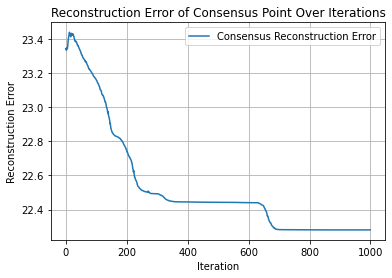

In [172]:
# List to store reconstruction errors of the consensus point at each iteration
consensus_errors = []

# Main iteration loop
for iteration in range(n_iterations):
    # Step 1: Calculate the consensus point
    consensus_point = compute_consensus_point(particles, alpha=0.001)

    # Step 2: Compute the reconstruction error for the consensus point
    consensus_tensor = cp_to_tensor((np.ones(rank), [consensus_point['A'], consensus_point['B'], consensus_point['C']]))
    consensus_error = tl.norm(tensor - consensus_tensor)

    # Print the reconstruction error of the consensus point
    print(f"Iteration {iteration + 1}/{n_iterations}, Consensus Reconstruction Error: {consensus_error}")

    # Store the error for later plotting
    consensus_errors.append(consensus_error)

    # Step 3: Update the particles
    isotropic_update(particles, consensus_point, lambda_, sigma, dt)
    # or use anisotropic_update(particles, consensus_point, lambda_, sigma, dt) if desired

# Final output: You could also save or analyze the final consensus point
final_consensus_point = compute_consensus_point(particles, alpha=0.001)
final_consensus_tensor = cp_to_tensor((np.ones(rank), [final_consensus_point['A'], final_consensus_point['B'], final_consensus_point['C']]))
final_error = tl.norm(tensor - final_consensus_tensor)

print("Final Consensus Reconstruction Error: ", final_error)

# Plotting the consensus reconstruction errors over iterations
plt.plot(consensus_errors, label='Consensus Reconstruction Error')
plt.xlabel('Iteration')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Consensus Point Over Iterations')
plt.legend()
plt.grid(True)
plt.show()